In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import opendatasets as od
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score


In [2]:
#   Using regression (predicts numerical values instead of classification which predicts categories), I will use either a
#   decission tree regressor, gradient forest regressor or gradient boost regressor to predict the mission success percentage
#   based on all other factors. 
#   1. first i will need to change the non-numerical values into numerical values such as launch dates, target type and 
#   mission type so that i can apply regression analysis.
#   2. Now i will need to extract the useful features from my data set, and discard ones such as mission ID and mission name. 
#   I will also need to convert the launch date into a numerical value, not just make date time object. I can do this by converting
#   the launch date into the number of days since a certain date, for example 1st January 2000.
#   3.  then I will need to perform a train test split on my data set to prepare for the regression model. This will be a 
#   gradient boost regressor for a few reasons; it works best with small data sets (<500 rows which i have), it is also
#   less likely intorduce errors in the data because it generates decission trees sequentially and fits them on
#   residual errors from previous trees rather than fitting them independently meaning that errors are fixed as they occur.
#   They also work well when highlihgting weaker trends in the data than other models.
#   However this method is slower than others like random forest regressor and is prone to overfitting if not tuned properly,
#   but this can be avoided with proper hyperparameter tuning and limiting the depth of the trees/data amount.
#   https://www.geeksforgeeks.org/machine-learning/gradient-boosting-vs-random-forest/
#   4. Then I will fit the model to the training data and make predictions on the test data, printing out the 
#   mean squared error, root mean squared error and r2 score to evaluate the model performance.



In [3]:
data= pd.read_csv('/workspaces/up2107120-ACT-CW2-repo/space-missions-dataset/space_missions_dataset.csv')

In [4]:
data.head()

,Mission ID,Mission Name,Launch Date,Target Type,Target Name,Mission Type,Distance from Earth (light-years),Mission Duration (years),Mission Cost (billion USD),Scientific Yield (points),Crew Size,Mission Success (%),Fuel Consumption (tons),Payload Weight (tons),Launch Vehicle
0,MSN-0001,Mission-1,2025-01-01,Star,Titan,Colonization,7.05,5.2,526.68,64.3,21,100.0,731.88,99.78,SLS
1,MSN-0002,Mission-2,2025-01-08,Exoplanet,Betelgeuse,Colonization,41.76,23.0,234.08,84.4,72,89.6,4197.41,45.72,Starship
2,MSN-0003,Mission-3,2025-01-15,Asteroid,Mars,Exploration,49.22,28.8,218.68,98.6,16,98.6,4908.00,36.12,Starship
3,MSN-0004,Mission-4,2025-01-22,Exoplanet,Titan,Colonization,26.33,17.8,232.89,36.0,59,90.0,2569.05,40.67,Starship
4,MSN-0005,Mission-5,2025-01-29,Exoplanet,Proxima b,Mining,8.67,9.2,72.14,96.5,31,73.2,892.76,12.40,Starship


In [5]:
data.tail()

,Mission ID,Mission Name,Launch Date,Target Type,Target Name,Mission Type,Distance from Earth (light-years),Mission Duration (years),Mission Cost (billion USD),Scientific Yield (points),Crew Size,Mission Success (%),Fuel Consumption (tons),Payload Weight (tons),Launch Vehicle
495,MSN-0496,Mission-496,2034-06-28,Planet,Betelgeuse,Colonization,48.26,25.3,274.82,91.2,64,96.2,4837.16,44.97,Ariane 6
496,MSN-0497,Mission-497,2034-07-05,Asteroid,Betelgeuse,Exploration,0.35,4.1,379.71,82.6,61,100.0,62.59,67.88,SLS
497,MSN-0498,Mission-498,2034-07-12,Planet,Ceres,Exploration,47.60,26.6,296.45,98.6,29,100.0,4794.01,51.38,Falcon Heavy
498,MSN-0499,Mission-499,2034-07-19,Planet,Betelgeuse,Research,31.99,18.0,457.38,77.9,39,100.0,3102.16,86.28,SLS
499,MSN-0500,Mission-500,2034-07-26,Planet,Io,Exploration,43.41,23.5,449.40,45.4,88,100.0,4302.93,86.74,Falcon Heavy


In [6]:
#changing target type to numerical values
data_aug= data.copy()#create a copy of the data to augment
target_types= data['Target Type'].unique()#giving each unoque target type a numerical value
target_type_mapping= {target: idx for idx, target in enumerate(target_types)}#maps target type to numerical val using enumerate each iteration


print("mapping a catagory to numerical val.")
for category, value in target_type_mapping.items():#print the key
    print(f"{category}: {value}")

data_aug['Target Type'] = data['Target Type'].map(target_type_mapping)#applying the target map to the data copy, data_aug

mapping a catagory to numerical val.
Star: 0
Exoplanet: 1
Asteroid: 2
Moon: 3
Planet: 4


In [7]:
#also changing all other non mumerical values to numerical values
#this includes columns: 'Mission Type', 'Target Name' and 'launch vehicle'

target_names= data_aug['Target Name'].unique()#giving each unique target name a numerical value
mission_types = data_aug['Mission Type'].unique()
launch_vehicle = data_aug['Launch Vehicle'].unique()
target_name_map= {target: idx for idx, target in enumerate(target_names)}#maps target type to numerical val using enumerate each iteration
mission_types_map= {mission: idx for idx, mission in enumerate(mission_types)}
launch_vehicle_map= {vehicle: idx for idx, vehicle in enumerate(launch_vehicle)}

for category, value in target_name_map.items():#print the key
    print(f"{category}: {value}")
print("\n")
for category, value in mission_types_map.items():#print the key
    print(f"{category}: {value}")
print("\n")
for category, value in launch_vehicle_map.items():#print the key
    print(f"{category}: {value}")

data_aug['Target Name'] = data_aug['Target Name'].map(target_name_map)
data_aug['Mission Type'] = data_aug['Mission Type'].map(mission_types_map)
data_aug['Launch Vehicle'] = data_aug['Launch Vehicle'].map(launch_vehicle_map)
data_aug.head()

Titan: 0
Betelgeuse: 1
Mars: 2
Proxima b: 3
Ceres: 4
Io: 5
Europa: 6


Colonization: 0
Exploration: 1
Mining: 2
Research: 3


SLS: 0
Starship: 1
Ariane 6: 2
Falcon Heavy: 3


,Mission ID,Mission Name,Launch Date,Target Type,Target Name,Mission Type,Distance from Earth (light-years),Mission Duration (years),Mission Cost (billion USD),Scientific Yield (points),Crew Size,Mission Success (%),Fuel Consumption (tons),Payload Weight (tons),Launch Vehicle
0,MSN-0001,Mission-1,2025-01-01,0,0,0,7.05,5.2,526.68,64.3,21,100.0,731.88,99.78,0
1,MSN-0002,Mission-2,2025-01-08,1,1,0,41.76,23.0,234.08,84.4,72,89.6,4197.41,45.72,1
2,MSN-0003,Mission-3,2025-01-15,2,2,1,49.22,28.8,218.68,98.6,16,98.6,4908.00,36.12,1
3,MSN-0004,Mission-4,2025-01-22,1,0,0,26.33,17.8,232.89,36.0,59,90.0,2569.05,40.67,1
4,MSN-0005,Mission-5,2025-01-29,1,3,2,8.67,9.2,72.14,96.5,31,73.2,892.76,12.40,1


In [8]:
#   However here I have realised that encoding like this for target type, name, mission type and launch vehicle may not
#   be the best way to do this. This is because numbering them like this introduces biases into the data, for example the 
#   model may think that target type 5 is better than target type 2 because of the higher numerical value when in reality
#   the SLS rocket is not ranked lower than the Falcon 9 rocket just because of its number.
#   A better way to do this may be to use one hot encoding which creates new columns for each category with binary values
#   indicating whether that row belongs to that category or not.
# 
# 
# 
#   https://www.geeksforgeeks.org/machine-learning/ml-one-hot-encoding/ and https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html

In [11]:
#one hot encoding my data. I am using the video One Hot Encoder with Python Machine Learning (Scikit-Learn) as reference https://www.youtube.com/watch?v=rsyrZnZ8J2o
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

data_2= data.copy()

#changing launch date to numerical value (number of days since 1st Jan 2000) https://www.geeksforgeeks.org/python/python-pandas-to_datetime/
data_2['Launch Date'] = pd.to_datetime(data_2['Launch Date'])#convert to datetime object
reference_date = pd.to_datetime('2000-01-01')#reference date
data_2['Launch Date'] = (data_2['Launch Date'] - reference_date).dt.days#convert to number of days since reference date

catagory_cols = ['Target Type', 'Target Name', 'Mission Type', 'Launch Vehicle']#listing the catagories for the one hot encoder
#number_cols = ['Launch Date','Distance from Earth (light-years)','Mission Duration (years)','Mission Cost (billion USD)','Scientific Yield (points)','Crew Size','Mission Success (%)','Fuel Consumption (tons)','Payload Weight (tons)']
X = data_2.drop(['Mission Success (%)', 'Mission ID', 'Mission Name'], axis=1)#splitting the data into useful features and target variable
y = data_2['Mission Success (%)']

catagory_cols = [c for c in catagory_cols if c in X.columns]#filtering the catagory columns 
number_cols = [c for c in X.columns if c not in catagory_cols]#filtering the numerical columns
print(catagory_cols)
print(number_cols)

X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.2, random_state=42)

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), catagory_cols)
    ], remainder='passthrough'
)
gbr = GradientBoostingRegressor(loss='absolute_error',      # uses L1 loss instead of default squared error
    learning_rate=0.1,          # step size for each tree
    n_estimators=300,           # number of sequential trees
    max_depth=1,                # each tree is a "stump" (very shallow)
    random_state=42,            # for reproducibility
    max_features=5              # max features considered per split
)

model = Pipeline(steps=[('preprocessor', preprocessor),
                        ('gradient decent regressor', gbr)])
model.fit(X_train, y_train)
pred_y = model.predict(X_test)



['Target Type', 'Target Name', 'Mission Type', 'Launch Vehicle']
['Launch Date', 'Distance from Earth (light-years)', 'Mission Duration (years)', 'Mission Cost (billion USD)', 'Scientific Yield (points)', 'Crew Size', 'Fuel Consumption (tons)', 'Payload Weight (tons)']


In [ ]:
#   even though this changing of the launch date to numerical value (the number of days from 1st Jan 2000 to launch date) 
#   has 'skewed' the data a bit, i do not need to perform another encoding method such as cyclical encoding because
#  the launch date is an affecting feature of the data set and would theoretically have some affect on the mission
#   sucess rate. (a mission launched further in the future may have better technology and therefore a higher chance of success)
#   https://www.geeksforgeeks.org/cyclical-encoding-in-machine-learning/

In [ ]:
from sklearn.metrics import mean_squared_error

test_rmse = mean_squared_error(y_test, pred_y) ** (1 / 2)
train_accuracy = gbr.score(X_train, y_train)
test_accuracy = gbr.score(X_test, y_test)
print(f"R² / training accuracy score: {train_accuracy:.4f}")
print(f"R² / testing accuracy score: {test_accuracy:.4f}")
print('Root mean Square error: {:.2f}'.format(test_rmse))

NameError: name 'y_test' is not defined

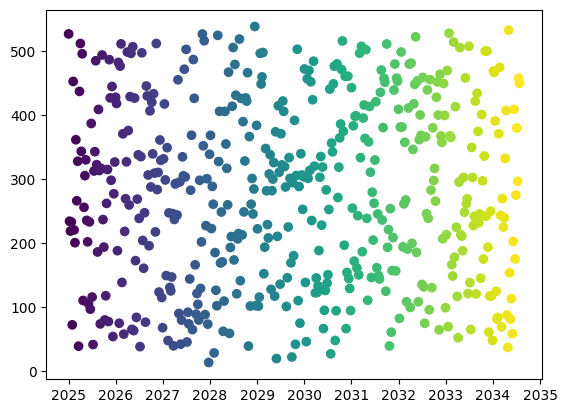

In [ ]:
plt.scatter(data_aug['Launch Date'], data_aug['Mission Cost (billion USD)'],c = np.linspace(0, 1, len(data_aug)), cmap='viridis')

In [ ]:
#applying regression model, data = space_data and target = mission success 
X = data_aug.drop('Mission Success (%)', axis=1)
y = data_aug['Mission Success (%)']
X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.2, random_state=42)
